<a href="https://colab.research.google.com/github/MartaCampagnoli/MLCatsandDogs/blob/main/5fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
from os import listdir
import pandas as pd
import numpy as np
import cv2
import PIL
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import random
import pathlib
from skimage.io import imread

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, callbacks, regularizers
from keras.models import Model, Sequential, load_model
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import  SGD, RMSprop, Adam
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix

!pip install visualkeras
import visualkeras
!pip install wget
import wget 
import zipfile


%load_ext tensorboard



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 36.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=3a04de20427d75ff6093a9a099a18bb082cc44f4bc9182c1799656d6201ea132
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
if not os.path.isfile("cats_vs_dogs.zip"): #downloading the dataset
    print("downloading...")
    wget.download("https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download")


downloading...


In [ ]:
if not (os.path.isdir("data") and os.path.isdir("data/Cats") and os.path.isdir("data/Dogs")): #unzipping
    print("extracting...")
    with zipfile.ZipFile("CatsDogs.zip", 'r') as file: file.extractall("./data/")

extracting...


In [ ]:
data_dir = "/content/data/CatsDogs"
cats_dir = data_dir + '/Cats'
dogs_dir = data_dir + '/Dogs'


In [ ]:
size = (100, 100)
channels = 1
catsdogs = []
categories = ['Cats','Dogs']

def get_data():

    for category in categories:
        path = os.path.join(data_dir, category)

        animalclass = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, size)
                catsdogs.append([new_array, animalclass])
            except:
                pass

get_data()

print(len(catsdogs))

24946


In [ ]:
random.shuffle(catsdogs)
#for sample in catsdogs[:4]:
    #print(sample[1])

In [ ]:
X = [] #getting the images and labels, casting them to tensor
y = []

for image, label in catsdogs:
    X.append(image)
    y.append(label)

X = np.array(X).reshape(-1, 100, 100, channels)
size = X.shape[0]
X = tf.convert_to_tensor(X, dtype= tf.float32) / 255.0
Y = tf.reshape(tf.convert_to_tensor(y, dtype=tf.float32), shape = [size, 1])

In [ ]:
#training loss, optimizers
                                         
loss = keras.losses.BinaryCrossentropy()

RMSProp = RMSprop(learning_rate=0.001)
ADAM = Adam()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.gray)

  
  if predictions_array == true_label:
    color = 'forestgreen'
  else:
    color = 'darkmagenta'

  plt.xlabel("{} ({})".format(categories[predictions_array],
                                categories[true_label]),
                                color=color)


##***5-fold cross-validation on Drop256 (dropout and convolutional layers) using RMSPROP***

In [ ]:
model_accuracy = []
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    drop256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    drop256.compile(optimizer = RMSProp, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = drop256.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = drop256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 5ms/step
Score for fold 1: Loss of 0.08136272545090184; Accuracy of 0.9186372745490982
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 6ms/step
Score for fold 2: Loss of 0.08478653036680694; Accuracy of 0.915213469633193
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 3: Loss of 0.0938063740228503; Accuracy of 0.9061936259771497
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 4: Loss of 0.09280416917217882; Accuracy of 0.9071958308278212
------------------------------------------------------------------------
Training 

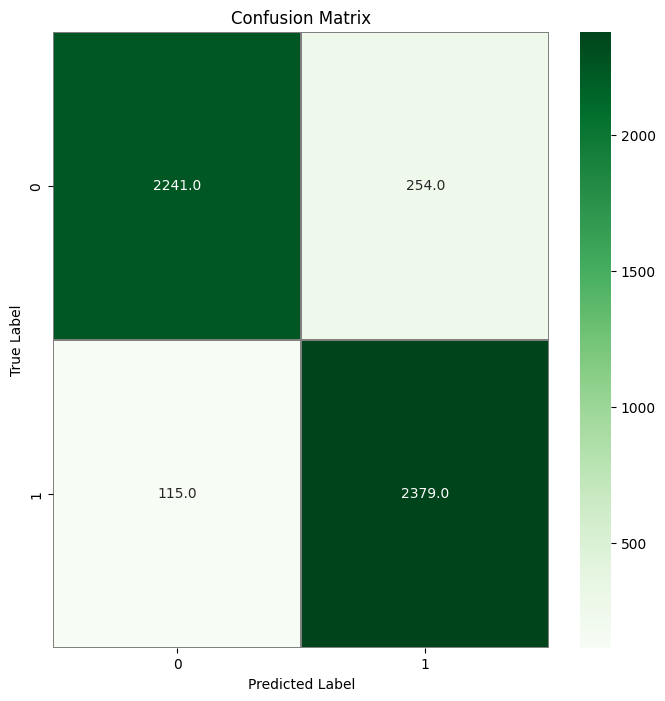

In [ ]:
#computing the confusion matrix for predictions for Fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
if y_predictions[0] > 0.5: #checking one prediction manually, just this one time
    print(f'It\'s a dog!')
else:
    print(f'It\'s a cat!')


It's a cat!


In [ ]:
y_predictions[0], y_predictions_np[0], y_test_np[0] #prediction and true label

(array([0.30891916], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32))

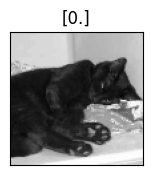

In [ ]:
plt.figure(figsize=(10,10)) #corresponding image
plt.subplot(5,5,i+1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_test[0], cmap=plt.cm.gray)
plt.title(y_test_np[0])
plt.show()

In [ ]:
#adapting arrays to use in the plot_image function

y_test_np = y_test_np.astype(int)
y_predictions_np = y_predictions_np.astype(int)
y_test_np1 = y_test_np.flatten()
y_pred_np1 = y_predictions_np.flatten()

out_images = np.array(X_test)

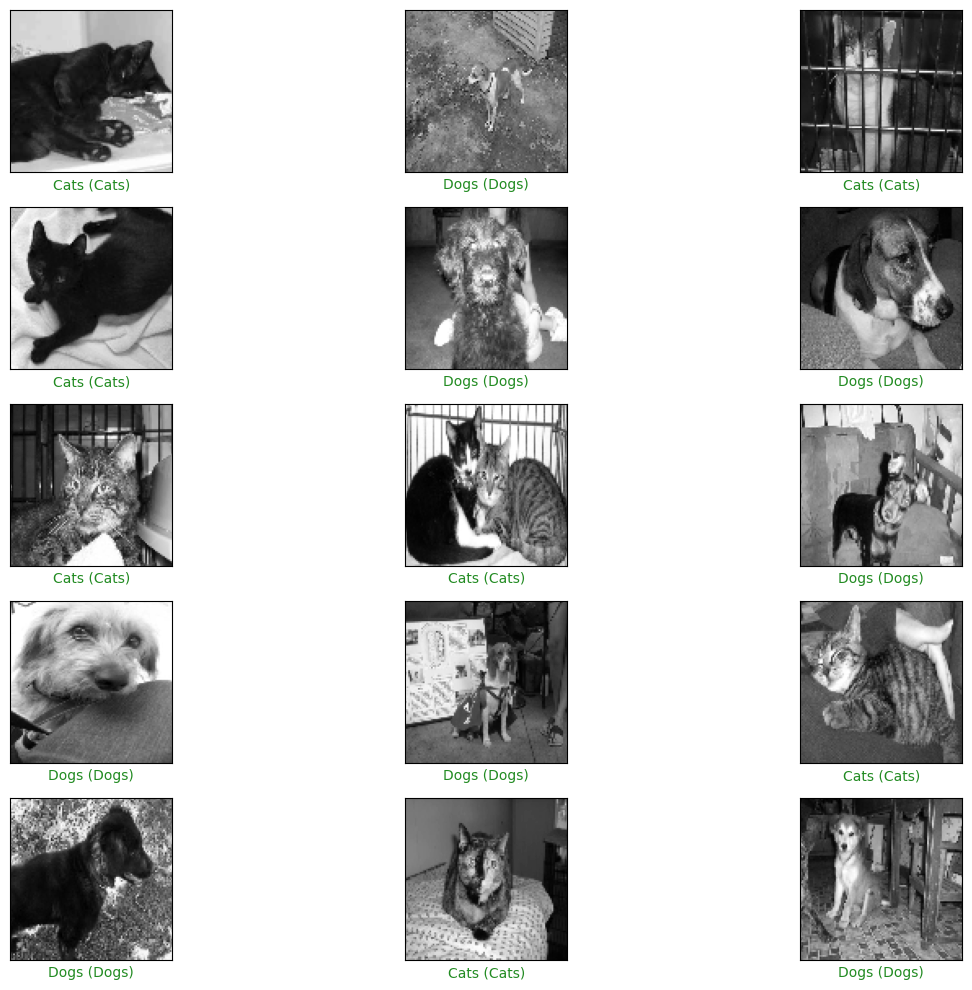

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# correct predictions are in green and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_np1[i], y_test_np1, out_images)
plt.tight_layout()
plt.show()


##***5-fold cross-validation on Drop256 (dropout and convolutional layers) using ADAM***

In [ ]:
model_accuracy = []
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    drop256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    drop256.compile(optimizer = ADAM, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = drop256.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = drop256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 0s 2ms/step
Score for fold 1: Loss of 0.06733466933867738; Accuracy of 0.9326653306613226
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 0s 2ms/step
Score for fold 2: Loss of 0.07496492283022649; Accuracy of 0.9250350771697735
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 0s 2ms/step
Score for fold 3: Loss of 0.0877931449188214; Accuracy of 0.9122068550811786
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 0s 2ms/step
Score for fold 4: Loss of 0.20284626177590703; Accuracy of 0.797153738224093
------------------------------------------------------------------------
Training 

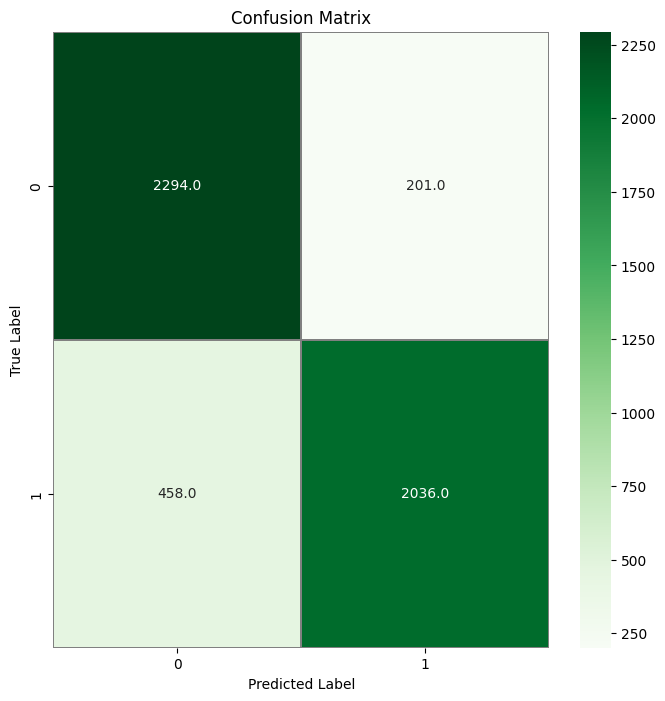

In [ ]:
#computing the confusion matrix for predictions for Fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#adapting arrays to use in the plot_image function

y_test_np = y_test_np.astype(int)
y_predictions_np = y_predictions_np.astype(int)
y_test_np1 = y_test_np.flatten()
y_pred_np1 = y_predictions_np.flatten()

out_images = np.array(X_test)

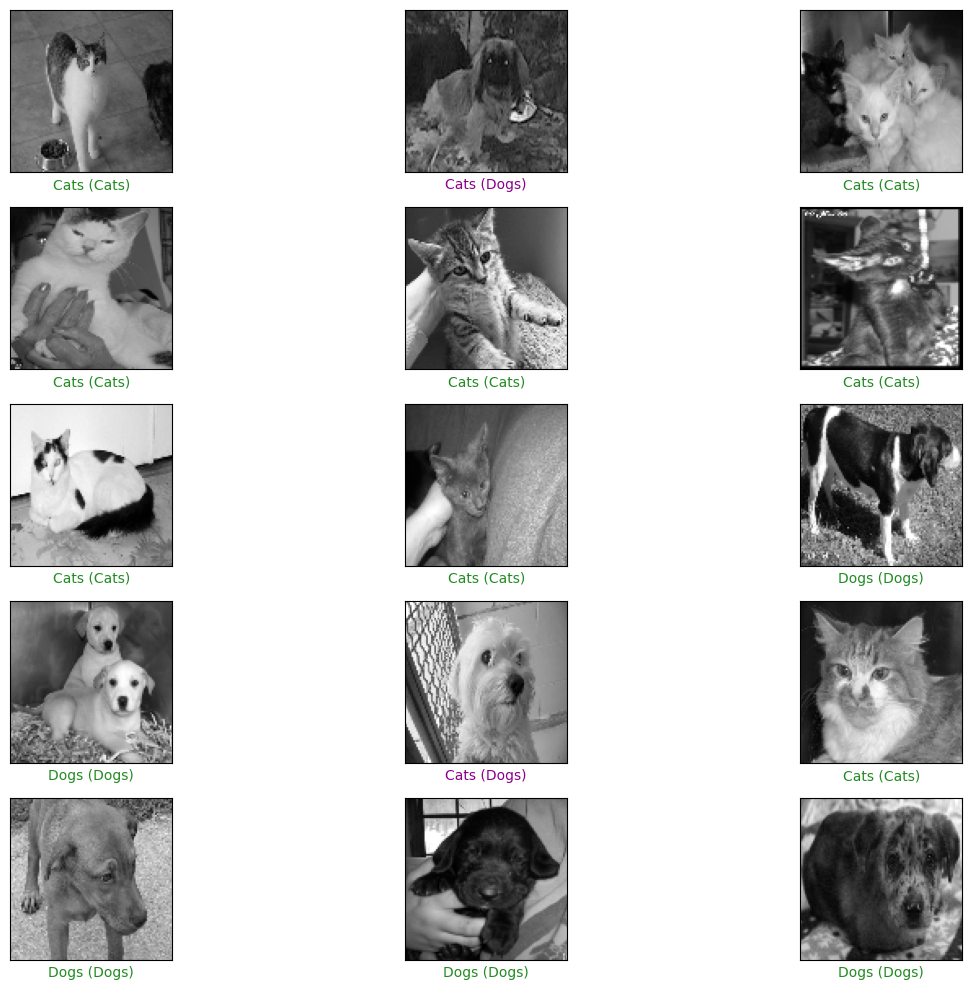

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# correct predictions are in green and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_np1[i], y_test_np1, out_images)
plt.tight_layout()
plt.show()


##***5-fold cross-validation on DropBatch256 (dropout, batch normalization and convolutional layers) using RMSPROP***

In [ ]:
model_accuracy = []
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])


    dropbatch256.compile(optimizer = RMSProp, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch256.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 1: Loss of 0.052505010020040044; Accuracy of 0.94749498997996
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 2: Loss of 0.05872920424934858; Accuracy of 0.9412707957506514
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 3: Loss of 0.05692523551813988; Accuracy of 0.9430747644818601
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 4: Loss of 0.061134495890960094; Accuracy of 0.9388655041090399
------------------------------------------------------------------------
Trainin

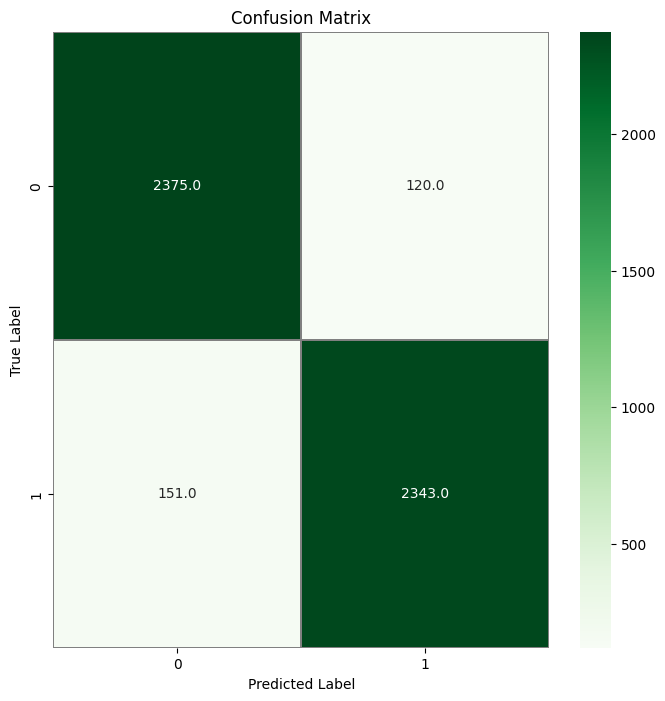

In [ ]:
# computing the confusion matrix for predictions for fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#adapting arrays to use in the plot_image function

y_test_np = y_test_np.astype(int)
y_predictions_np = y_predictions_np.astype(int)
y_test_np1 = y_test_np.flatten()
y_pred_np1 = y_predictions_np.flatten()

out_images = np.array(X_test)

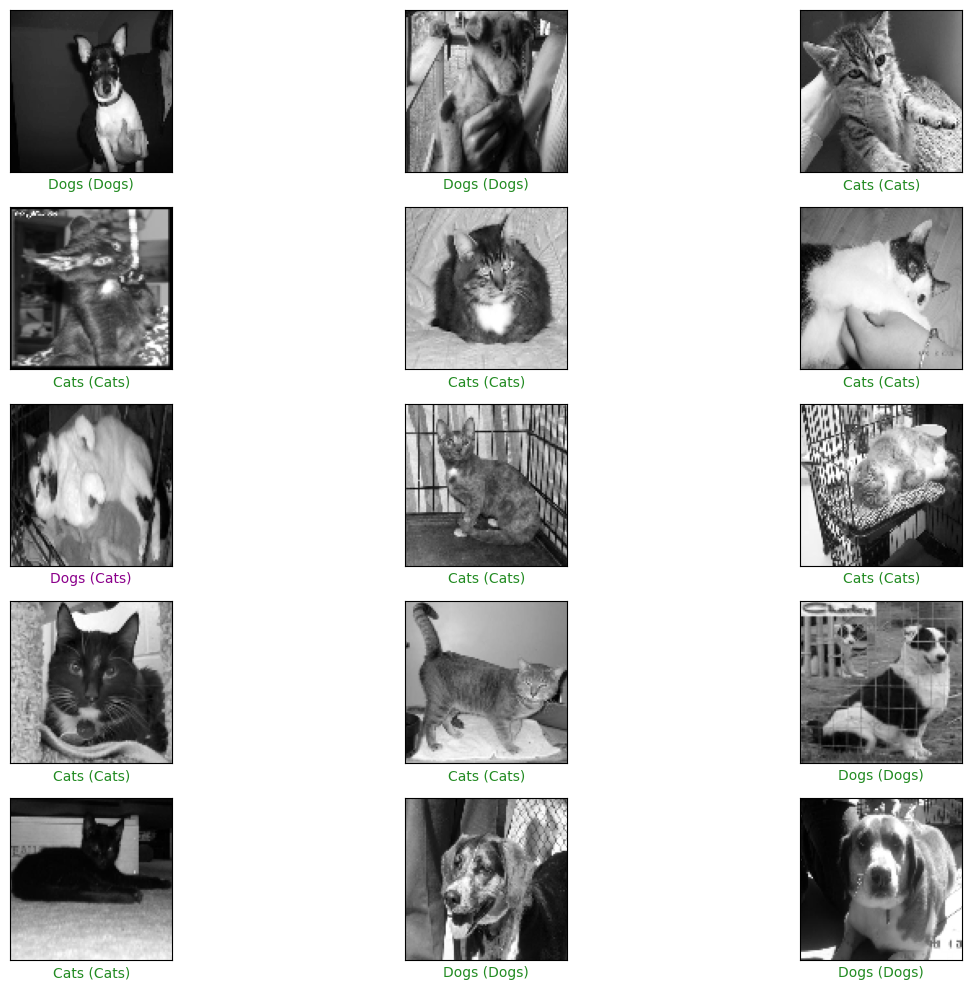

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# correct predictions are in green and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_np1[i], y_test_np1, out_images)
plt.tight_layout()
plt.show()


##***5-fold cross-validation on DropBatch256 (dropout, batch normalization and convolutional layers) using ADAM***

In [ ]:
model_accuracy = []
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])


    dropbatch256.compile(optimizer = ADAM, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch256.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 1: Loss of 0.060921843687374744; Accuracy of 0.9390781563126253
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 2: Loss of 0.05792744036881137; Accuracy of 0.9420725596311886
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 3: Loss of 0.05211465223491685; Accuracy of 0.9478853477650832
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 4: Loss of 0.06313890559230306; Accuracy of 0.9368610944076969
------------------------------------------------------------------------
Traini

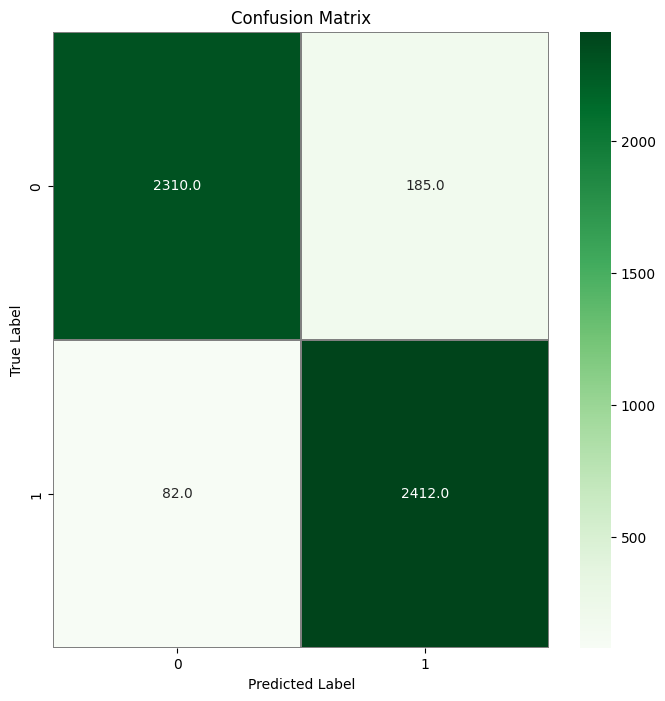

In [ ]:
# computing the confusion matrix for predictions for fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#adapting arrays to use in the plot_image function

y_test_np = y_test_np.astype(int)
y_predictions_np = y_predictions_np.astype(int)
y_test_np1 = y_test_np.flatten()
y_pred_np1 = y_predictions_np.flatten()

out_images = np.array(X_test)

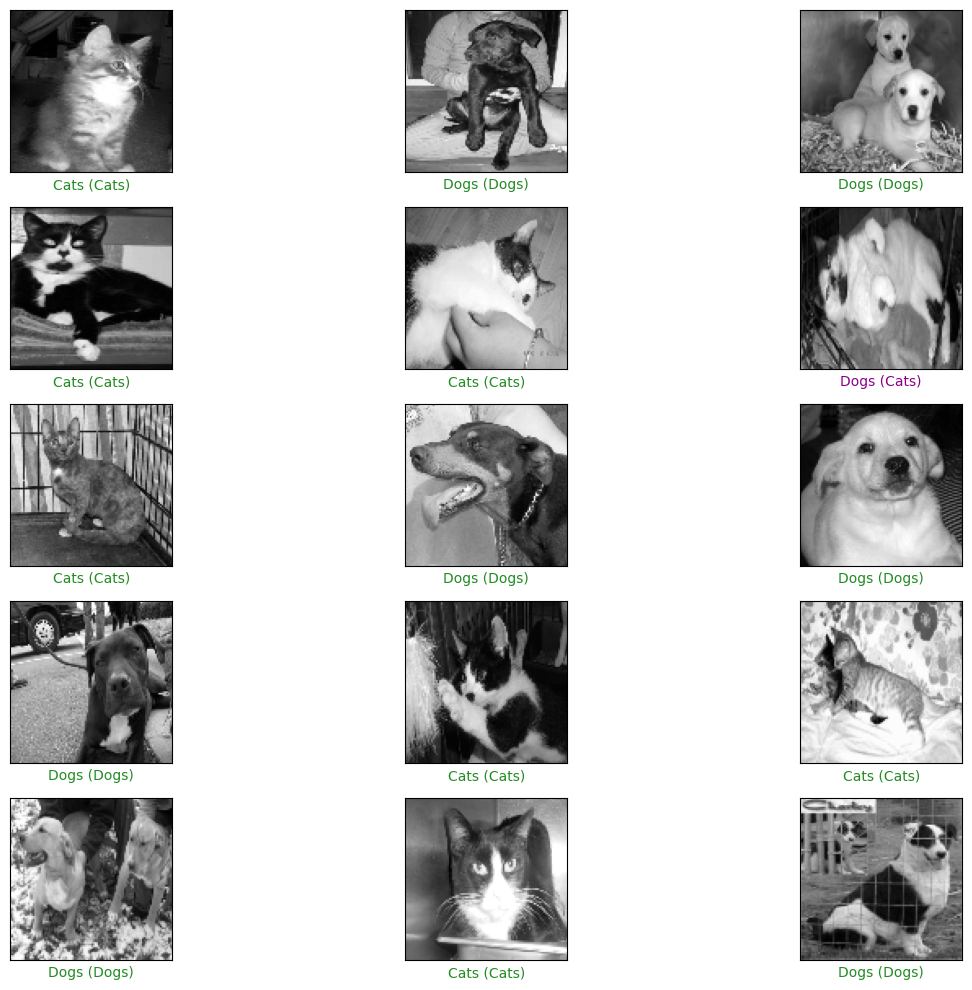

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# correct predictions are in green and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_np1[i], y_test_np1, out_images)
plt.tight_layout()
plt.show()


##***5-fold cross-validation on DropBatch512 (dropout, batch normalization and convolutional layers) using RMSPROP***

In [ ]:
model_accuracy = []
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch512 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    dropbatch512.compile(optimizer = RMSProp, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch512.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch512.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 5ms/step
Score for fold 1: Loss of 0.06893787575150301; Accuracy of 0.931062124248497
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 5ms/step
Score for fold 2: Loss of 0.0731609540990178; Accuracy of 0.9268390459009822
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 3: Loss of 0.061134495890960094; Accuracy of 0.9388655041090399
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 4: Loss of 0.061535377831228755; Accuracy of 0.9384646221687712
------------------------------------------------------------------------
Trainin

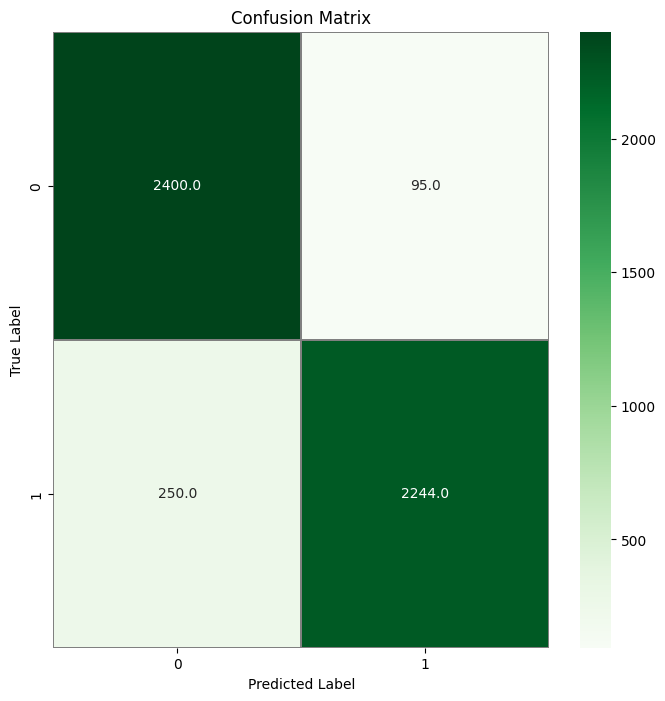

In [ ]:
# computing the confusion matrix for predictions at Fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#adapting arrays to use in the plot_image function

y_test_np = y_test_np.astype(int)
y_predictions_np = y_predictions_np.astype(int)
y_test_np1 = y_test_np.flatten()
y_pred_np1 = y_predictions_np.flatten()

out_images = np.array(X_test)

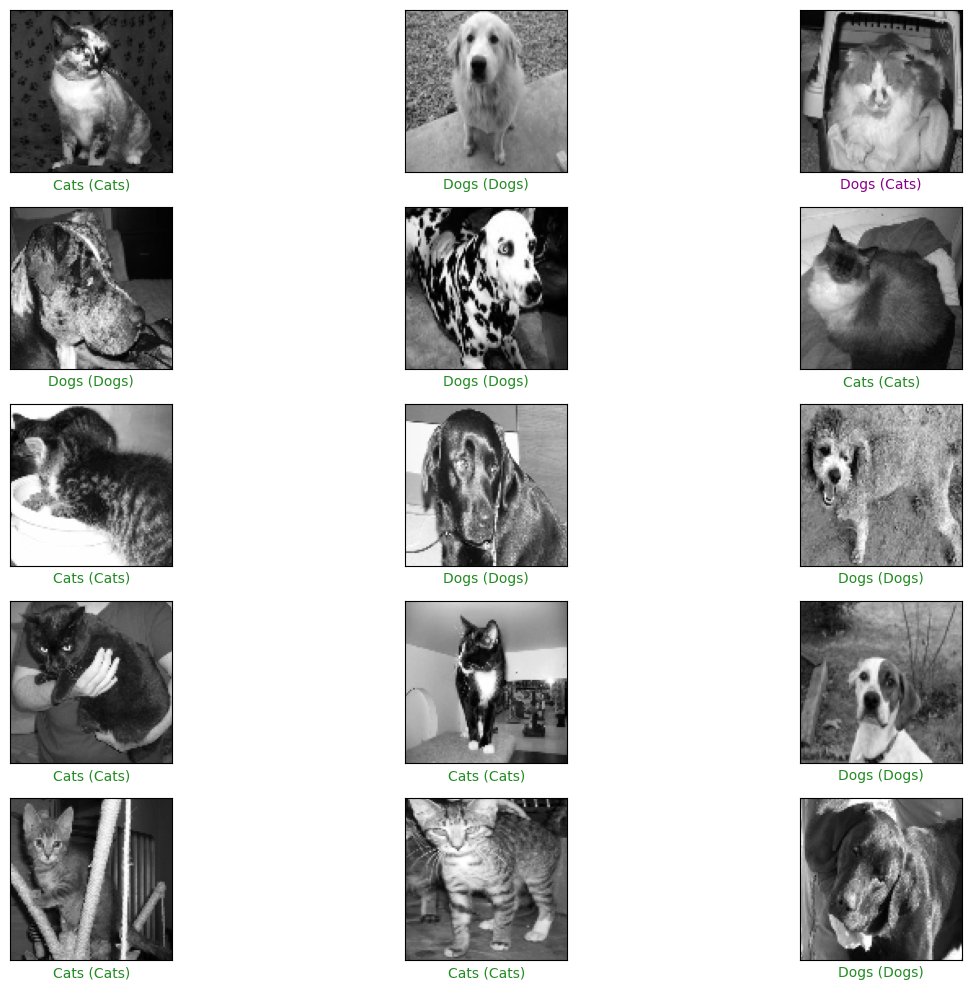

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# correct predictions are in green and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_np1[i], y_test_np1, out_images)
plt.tight_layout()
plt.show()


##***5-fold cross-validation on DropBatch512 (dropout, batch normalization and convolutional layers) using ADAM***

In [ ]:
model_accuracy = []
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch512 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    dropbatch512.compile(optimizer = ADAM, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch512.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch512.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 1: Loss of 0.05210420841683372; Accuracy of 0.9478957915831663
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 2: Loss of 0.0645419923832431; Accuracy of 0.9354580076167569
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 3: Loss of 0.06414111044297455; Accuracy of 0.9358588895570255
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 4ms/step
Score for fold 4: Loss of 0.05712567648827416; Accuracy of 0.9428743235117258
------------------------------------------------------------------------
Training

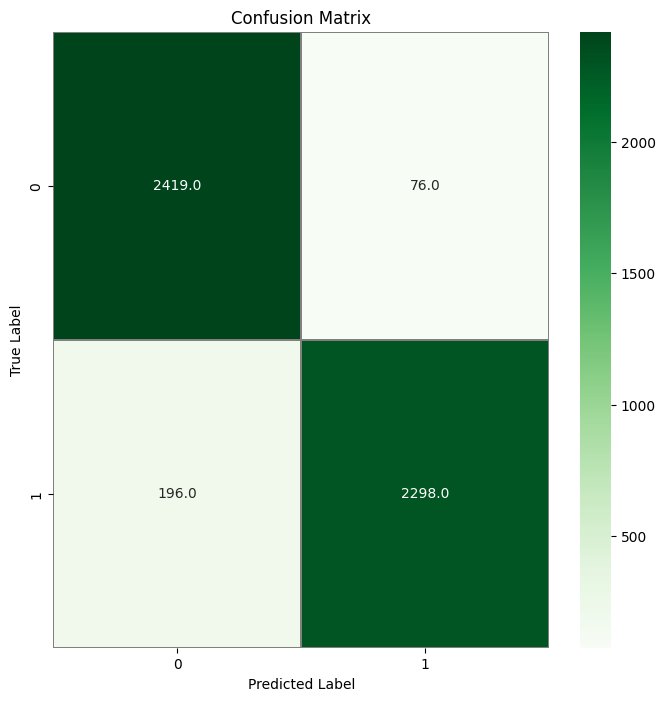

In [ ]:
# computing the confusion matrix for predictions at Fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#adapting arrays to use in the plot_image function

y_test_np = y_test_np.astype(int)
y_predictions_np = y_predictions_np.astype(int)
y_test_np1 = y_test_np.flatten()
y_pred_np1 = y_predictions_np.flatten()

out_images = np.array(X_test)

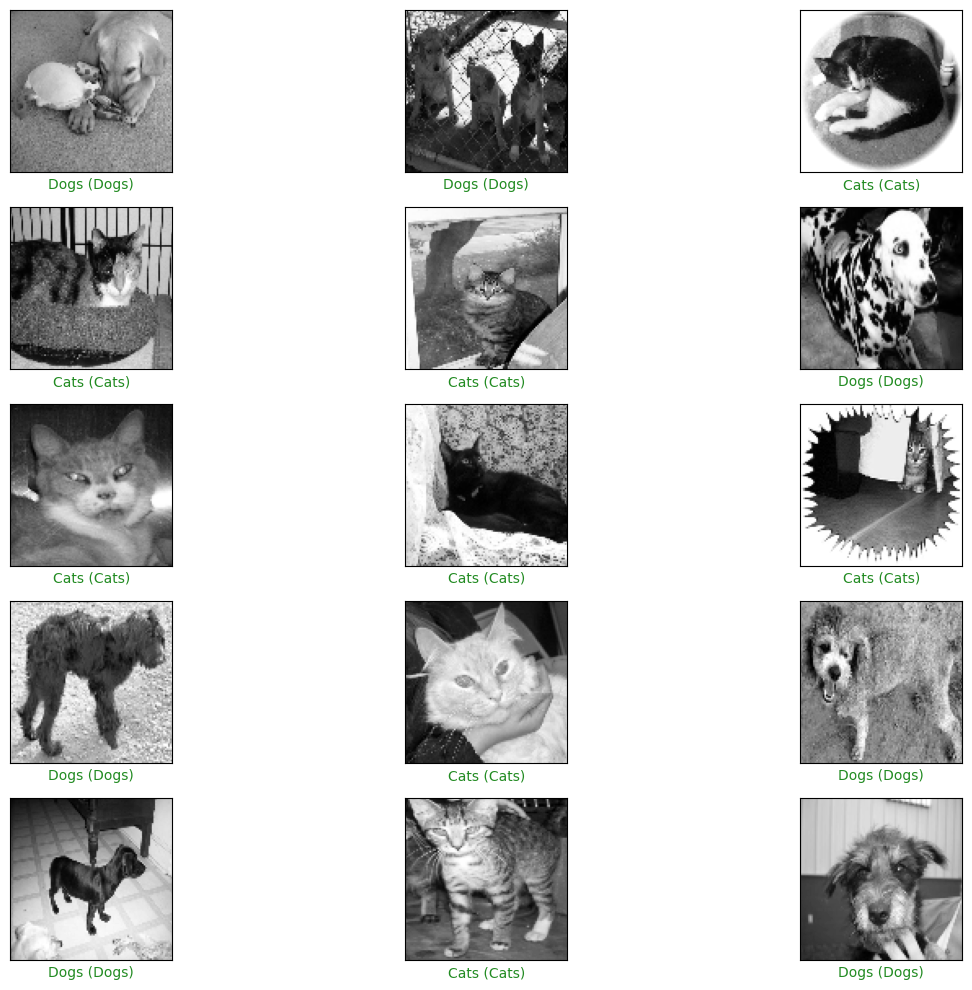

In [ ]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# correct predictions are in green and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_np1[i], y_test_np1, out_images)
plt.tight_layout()
plt.show()


##***Best Model: further experiments on DropBatch256***

A last batch of training experiments is conducted on the best performing models changing one of the hyperparameters. Specifically:

1.   The first training experiment uses Leaky Relu as activation function
2.   The second training experiment uses Rmsprop with initial learning rate se to 0.002
3.   The third sets the bacth size to 32






In [ ]:
leakyr = tf.keras.layers.LeakyReLU(alpha=0.01) #hyperparameters
RMSProp2 = RMSprop(learning_rate=0.002)

In [ ]:
model_accuracy = [] #LEAKYRELU
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation= leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation= leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation= leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation= leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation=leakyr),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])


    dropbatch256.compile(optimizer = RMSProp, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch256.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 5ms/step
Score for fold 1: Loss of 0.049498997995992; Accuracy of 0.950501002004008
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 5ms/step
Score for fold 2: Loss of 0.052916416115453946; Accuracy of 0.947083583884546
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 3: Loss of 0.05732611745840854; Accuracy of 0.9426738825415915
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 4: Loss of 0.0653437562637803; Accuracy of 0.9346562437362197
------------------------------------------------------------------------
Training fo

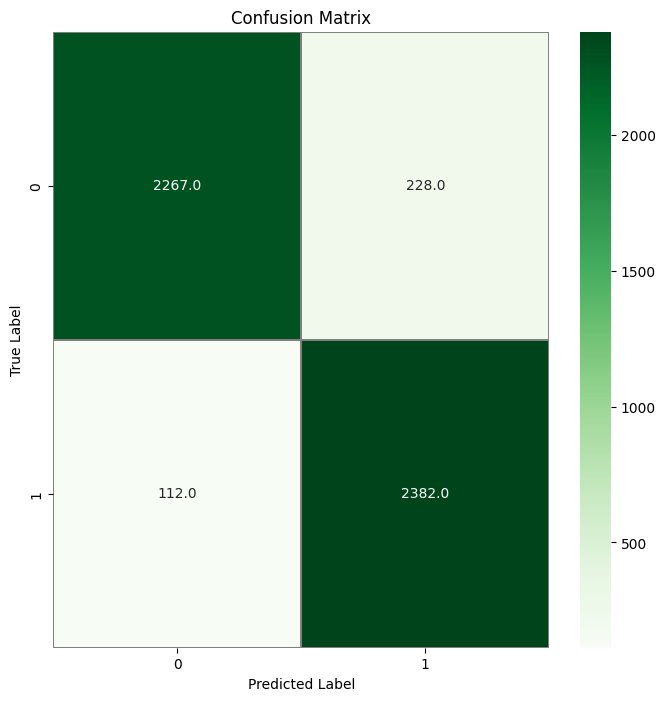

In [ ]:
# computing the confusion matrix for predictions at fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model_accuracy = [] #rmsprop, different starting learning rate
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])


    dropbatch256.compile(optimizer = RMSProp2, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch256.fit(X_train, y_train, epochs = 50, batch_size = 64, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 1: Loss of 0.05450901803607211; Accuracy of 0.9454909819639279
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 2: Loss of 0.06955301663660052; Accuracy of 0.9304469833633995
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 3: Loss of 0.08117859290438967; Accuracy of 0.9188214070956103
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 4: Loss of 0.060332732010422885; Accuracy of 0.9396672679895771
------------------------------------------------------------------------
Traini

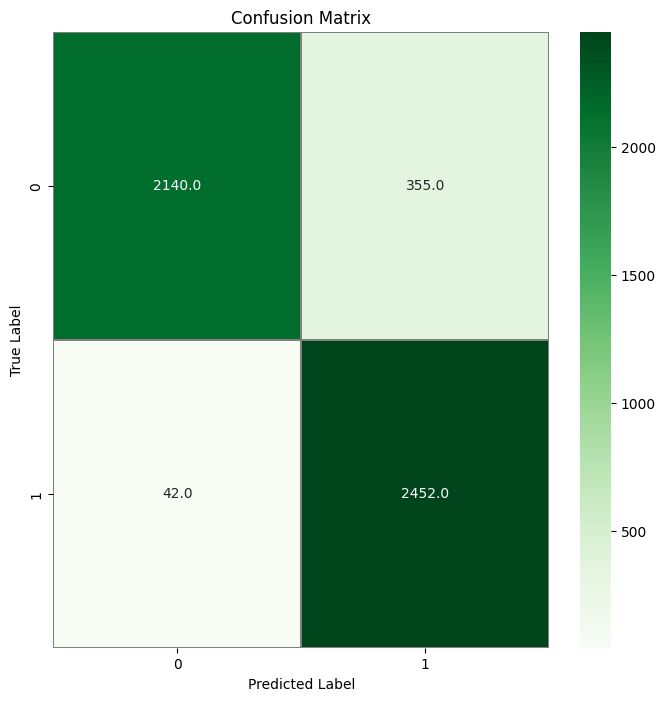

In [ ]:
# computing the confusion matrix for predictions at Fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model_accuracy = []  #batch size 32
model_loss = []


splits = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True)


fold_num = 1
for train, test in kfold.split(X, Y):

    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

    dropbatch256 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])


    dropbatch256.compile(optimizer = RMSProp, loss=loss, metrics=['binary_accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = dropbatch256.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

    #predicting and rounding to 0 and 1, computing the zero-one loss

    y_predictions = dropbatch256.predict(X_test)
    y_predictions_np = tf.round(y_predictions).numpy()
    y_test_np = y_test.numpy() #true test labels

    model_accuracy.append(accuracy_score(y_test_np, y_predictions_np))
    model_loss.append(zero_one_loss(y_test_np, y_predictions_np))

#metrics for each fold
    print(f'Score for fold {fold_num}: Loss of {zero_one_loss(y_test_np, y_predictions_np)}; Accuracy of {accuracy_score(y_test_np, y_predictions_np)}')

    fold_num = fold_num + 1

#average metrics
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(model_loss)):
    print(f'> Fold {i + 1} - Loss: {model_loss[i]} - Accuracy: {model_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(model_accuracy)} (+- {np.std(model_accuracy)})')
print(f'> Zero-one Loss: {np.mean(model_loss)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 1: Loss of 0.06953907815631266; Accuracy of 0.9304609218436873
------------------------------------------------------------------------
Training for fold 2 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 2: Loss of 0.056524353577871334; Accuracy of 0.9434756464221287
------------------------------------------------------------------------
Training for fold 3 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 3: Loss of 0.05692523551813988; Accuracy of 0.9430747644818601
------------------------------------------------------------------------
Training for fold 4 ...
156/156 [==============================] - 1s 3ms/step
Score for fold 4: Loss of 0.055722589697334124; Accuracy of 0.9442774103026659
------------------------------------------------------------------------
Train

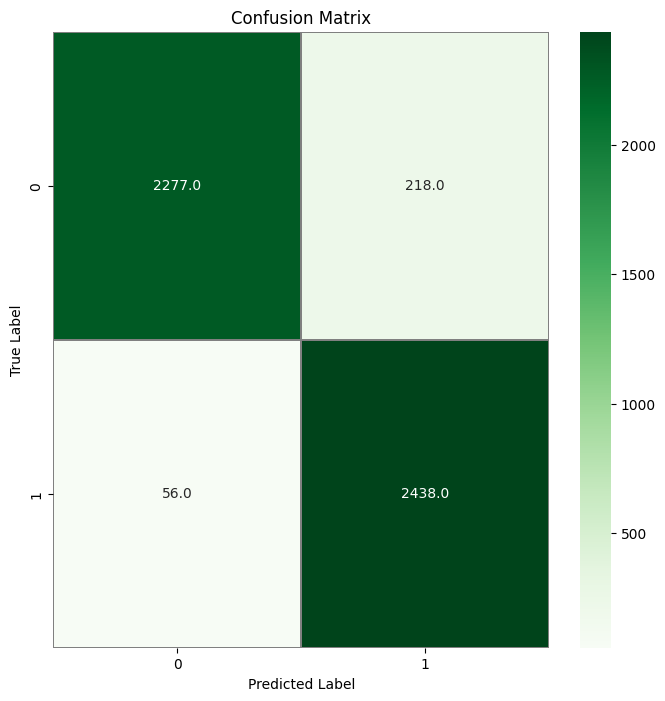

In [ ]:
# computing the confusion matrix for predictions at Fold 5
confusion_mtx = confusion_matrix(y_test_np, y_predictions_np) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()